In [147]:
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.applications import EfficientNetV2S
from keras.utils import load_img, img_to_array, to_categorical, pad_sequences, image_dataset_from_directory, plot_model
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.text import Tokenizer
from keras.models import Model, Sequential
from keras.layers import MaxPooling2D, Flatten, Dense, Dropout, Conv2D, LSTM, Embedding, Add, Input
from sklearn.model_selection import train_test_split
from os import listdir
import os
import shutil
import re
import nltk
from nltk.corpus import stopwords
from PIL import Image


In [148]:
imagefolder = 'flickr8k/images/'
imagesize = 224

In [149]:
df1 = pd.read_pickle('caption1')
df1.head()

caption_order,image,1
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting
2,1002674143_1b742ab4b8.jpg,A little girl covered in paint sits in front o...
3,1003163366_44323f5815.jpg,A man lays on a bench while his dog sits by him .
4,1007129816_e794419615.jpg,A man in an orange hat starring at something .


In [150]:
df1.rename(columns={1:'caption1'},inplace=True)
df1.head()

caption_order,image,caption1
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting
2,1002674143_1b742ab4b8.jpg,A little girl covered in paint sits in front o...
3,1003163366_44323f5815.jpg,A man lays on a bench while his dog sits by him .
4,1007129816_e794419615.jpg,A man in an orange hat starring at something .


In [151]:
#Sample the dataset because potato computer
df1_sample, _, _, _ = train_test_split(df1, df1, train_size=0.2, random_state=2)

In [152]:
df1_sample.shape

(1618, 2)

## Preprocessing begins

In [153]:
#Captions need to be made into all lower case with special characters removed
#Captions will be stripped of extra spaces
#Captions are sequenced, so a start and an end marker are needed
df1_sample['caption1'] = df1_sample['caption1'].apply(lambda text: text.lower())
df1_sample['caption1'] = df1_sample['caption1'].apply(lambda text: re.sub(r'[^\w\s]', '', text))
df1_sample['caption1'] = df1_sample['caption1'].apply(lambda text: text.strip())
df1_sample['caption1'] = 'start ' + df1_sample['caption1'] + ' end'

In [154]:
df1_sample['caption1']

6687    start a blond girl and brunette brown hanging ...
6793    start a bmx rider in a red and black outfit is...
7916      start a dog is jumping to play in the water end
3742    start a group of greyhound dogs racing with mu...
2122    start a dog with a frisbee in front of a brown...
                              ...                        
3606    start a boy jumps through the air onto somethi...
5704       start a man rides a ski lift up a mountain end
6637    start a man has his hands up while standing ne...
2575    start a float representing the times of hangin...
7336    start a brown dog leaps up to catch an orange ...
Name: caption1, Length: 1618, dtype: object

For my model, I will keep all stop words in captions. This is because the model is meant to ultimately generate a caption for an input image, and generated captions, like any sentence, don't make sense without stop words. To include them in generation, I will include them in training.

However, to assess the frequency of meaningful words, I will create a stopword-free tokenized list.

In [155]:
#stop word removal option for tokenization
stops = set(stopwords.words('english'))
print(stops)

{'ve', "hasn't", 'nor', 'just', 'my', 'been', 'mightn', 'itself', "haven't", 'shouldn', "don't", "weren't", 'this', 'me', 'yourself', 'isn', 'having', 'more', 'themselves', "you'll", 'they', 'any', 'them', 'if', "won't", 'in', 'her', 'do', 'only', 's', 'up', 'our', 'he', 'm', "that'll", 're', 'again', 'here', 'few', 'with', "you've", 'should', 'doesn', 'myself', 'all', 'what', 'as', "mightn't", 'can', 'and', "shouldn't", "she's", 'against', 'through', 'below', 'by', 'we', 'no', 'because', 'yours', 'you', 't', 'will', 'its', 'for', 'so', 'ma', 'weren', 'down', 'before', 'once', 'wasn', 'to', "needn't", 'each', 'haven', 'theirs', 'ourselves', 'very', 'don', "didn't", 'not', 'about', 'on', 'those', 'him', 'during', 'where', 'than', 'have', 'their', 'hers', 'being', 'aren', 'until', 'y', 'wouldn', 'it', 'at', 'but', 'whom', "wasn't", 'into', 'when', 'there', 'that', 'be', 'which', 'is', 'further', 'these', 'then', 'such', 'too', 'both', 'of', 'off', 'herself', 'does', 'am', 'under', 'could

In [156]:
#stop word removal option for tokenization
def remove_stop_words(sentence):
    words = nltk.word_tokenize(sentence)
    filtered_words = [word for word in words if word.lower() not in stops]
    return ' '.join(filtered_words)

In [157]:
#Create new caption column with no stop words
df1_sample['captions_no_stopwords'] = df1_sample['caption1'].apply(remove_stop_words)

In [158]:
df1_sample.head()

caption_order,image,caption1,captions_no_stopwords
6687,3644142276_caed26029e.jpg,start a blond girl and brunette brown hanging ...,start blond girl brunette brown hanging gymnas...
6793,3670907052_c827593564.jpg,start a bmx rider in a red and black outfit is...,start bmx rider red black outfit jumping motor...
7916,774009278_8e75b7d498.jpg,start a dog is jumping to play in the water end,start dog jumping play water end
3742,3027399066_ca85495775.jpg,start a group of greyhound dogs racing with mu...,start group greyhound dogs racing muzzles cove...
2122,2511019188_ca71775f2d.jpg,start a dog with a frisbee in front of a brown...,start dog frisbee front brown dog end


In [159]:
tokenizernostop = Tokenizer()
tokenizernostop.fit_on_texts(df1_sample['captions_no_stopwords'])
df1_sample['tokenized_nostops'] = tokenizernostop.texts_to_sequences(df1_sample['captions_no_stopwords'])

In [160]:
df1_sample.head()

caption_order,image,caption1,captions_no_stopwords,tokenized_nostops
6687,3644142276_caed26029e.jpg,start a blond girl and brunette brown hanging ...,start blond girl brunette brown hanging gymnas...,"[2, 144, 7, 834, 9, 248, 835, 348, 1]"
6793,3670907052_c827593564.jpg,start a bmx rider in a red and black outfit is...,start bmx rider red black outfit jumping motor...,"[2, 426, 162, 14, 5, 209, 26, 151, 1]"
7916,774009278_8e75b7d498.jpg,start a dog is jumping to play in the water end,start dog jumping play water end,"[2, 3, 26, 77, 10, 1]"
3742,3027399066_ca85495775.jpg,start a group of greyhound dogs racing with mu...,start group greyhound dogs racing muzzles cove...,"[2, 12, 210, 27, 163, 565, 566, 567, 1]"
2122,2511019188_ca71775f2d.jpg,start a dog with a frisbee in front of a brown...,start dog frisbee front brown dog end,"[2, 3, 126, 30, 9, 3, 1]"


In [161]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df1_sample['caption1'])
df1_sample['tokenized'] = tokenizer.texts_to_sequences(df1_sample['caption1'])

In [162]:
df1_sample.head()

caption_order,image,caption1,captions_no_stopwords,tokenized_nostops,tokenized
6687,3644142276_caed26029e.jpg,start a blond girl and brunette brown hanging ...,start blond girl brunette brown hanging gymnas...,"[2, 144, 7, 834, 9, 248, 835, 348, 1]","[3, 1, 181, 15, 7, 901, 17, 296, 48, 902, 400, 2]"
6793,3670907052_c827593564.jpg,start a bmx rider in a red and black outfit is...,start bmx rider red black outfit jumping motor...,"[2, 426, 162, 14, 5, 209, 26, 151, 1]","[3, 1, 484, 202, 4, 1, 28, 7, 13, 254, 8, 41, ..."
7916,774009278_8e75b7d498.jpg,start a dog is jumping to play in the water end,start dog jumping play water end,"[2, 3, 26, 77, 10, 1]","[3, 1, 9, 8, 41, 20, 105, 4, 5, 22, 2]"
3742,3027399066_ca85495775.jpg,start a group of greyhound dogs racing with mu...,start group greyhound dogs racing muzzles cove...,"[2, 12, 210, 27, 163, 565, 566, 567, 1]","[3, 1, 26, 10, 255, 42, 203, 12, 626, 627, 93,..."
2122,2511019188_ca71775f2d.jpg,start a dog with a frisbee in front of a brown...,start dog frisbee front brown dog end,"[2, 3, 126, 30, 9, 3, 1]","[3, 1, 9, 12, 1, 161, 4, 47, 10, 1, 17, 9, 2]"


In [163]:
# Max length of a caption will be needed when the sequences are created
max_length = max(len(d.split()) for d in df1_sample['caption1'])
max_length

33

In [164]:
# Vocab size will be needed for modeling. This one includes stop words
vocab_size = len(tokenizer.word_index) + 1
print(f'Vocabulary Size:  {vocab_size}')

Vocabulary Size:  1982


In [165]:
tokenizernostop.word_index

{'end': 1,
 'start': 2,
 'dog': 3,
 'man': 4,
 'black': 5,
 'boy': 6,
 'girl': 7,
 'white': 8,
 'brown': 9,
 'water': 10,
 'woman': 11,
 'group': 12,
 'two': 13,
 'red': 14,
 'people': 15,
 'blue': 16,
 'shirt': 17,
 'ball': 18,
 'playing': 19,
 'wearing': 20,
 'standing': 21,
 'child': 22,
 'another': 23,
 'running': 24,
 'grass': 25,
 'jumping': 26,
 'dogs': 27,
 'green': 28,
 'snow': 29,
 'front': 30,
 'sitting': 31,
 'beach': 32,
 'holding': 33,
 'near': 34,
 'yellow': 35,
 'player': 36,
 'walking': 37,
 'field': 38,
 'runs': 39,
 'pink': 40,
 'children': 41,
 'mouth': 42,
 'bike': 43,
 'orange': 44,
 'stands': 45,
 'jumps': 46,
 'person': 47,
 'crowd': 48,
 'street': 49,
 'air': 50,
 'jacket': 51,
 'soccer': 52,
 'behind': 53,
 'toy': 54,
 'little': 55,
 'three': 56,
 'camera': 57,
 'dressed': 58,
 'riding': 59,
 'large': 60,
 'hat': 61,
 'looking': 62,
 'along': 63,
 'plays': 64,
 'next': 65,
 'dirt': 66,
 'one': 67,
 'pool': 68,
 'park': 69,
 'young': 70,
 'across': 71,
 'baby':

In [166]:
tokenizernostop.word_counts

OrderedDict([('start', 1618),
             ('blond', 13),
             ('girl', 173),
             ('brunette', 1),
             ('brown', 143),
             ('hanging', 6),
             ('gymnastic', 1),
             ('ropes', 4),
             ('end', 1623),
             ('bmx', 3),
             ('rider', 11),
             ('red', 93),
             ('black', 227),
             ('outfit', 8),
             ('jumping', 64),
             ('motorcycle', 12),
             ('dog', 373),
             ('play', 23),
             ('water', 116),
             ('group', 95),
             ('greyhound', 8),
             ('dogs', 63),
             ('racing', 11),
             ('muzzles', 2),
             ('covering', 2),
             ('noses', 2),
             ('frisbee', 15),
             ('front', 58),
             ('woman', 98),
             ('watching', 9),
             ('two', 94),
             ('kids', 15),
             ('playing', 79),
             ('pool', 27),
             ('man', 306),
    

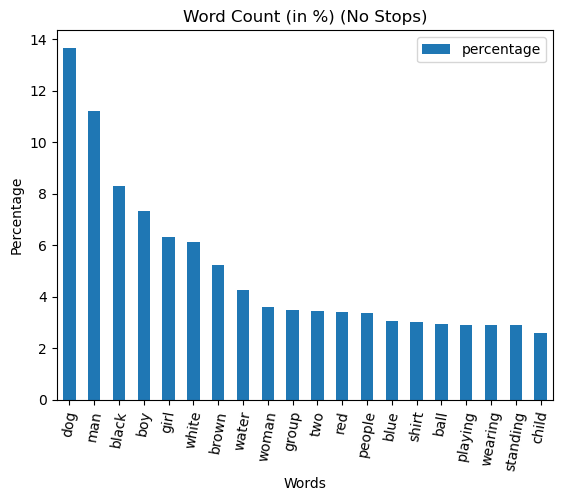

In [234]:
word_frequency = pd.DataFrame(data=tokenizernostop.word_counts.items(), columns=["word", "count"])
# Exclude start and end
exclude_words = ["start", "end"]
word_frequency = word_frequency[~word_frequency['word'].isin(exclude_words)]
# Sort the dataframe by count in descending order and select top 20
word_frequency = word_frequency.sort_values("count", ascending=False).head(20)
# Total for %
total_count = word_frequency['count'].sum()
# Calculate the percentage for each word
word_frequency['percentage'] = (word_frequency['count'] / total_count) * 100
# Plot the bar chart
word_frequency.set_index("word").plot(kind="bar", y="percentage", rot=0, title="Word Count (in %) (No Stops)")
plt.ylabel('Percentage')
plt.xlabel('Words')
plt.xticks(rotation=80)
# Display the plot
plt.show()

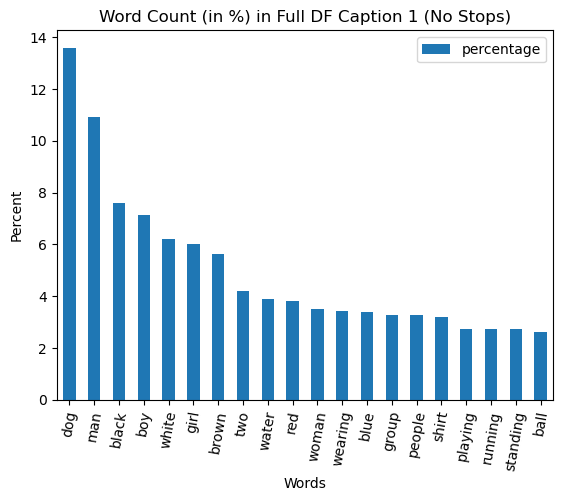

In [168]:
df1['cnostop'] = df1['caption1'].apply(remove_stop_words)
tokenizerfulldfnostop = Tokenizer()
tokenizerfulldfnostop.fit_on_texts(df1['cnostop'])
df1['tokenized_nostops'] = tokenizerfulldfnostop.texts_to_sequences(df1['cnostop'])
word_frequency = pd.DataFrame(data=tokenizerfulldfnostop.word_counts.items(), columns=["word", "count"])
# Exclude start and end
exclude_words = ["start", "end"]
word_frequency = word_frequency[~word_frequency['word'].isin(exclude_words)]
# Sort the dataframe by count in descending order and select top 20
word_frequency = word_frequency.sort_values("count", ascending=False).head(20)
# Total for %
total_count = word_frequency['count'].sum()
# Calculate the percentage for each word
word_frequency['percentage'] = (word_frequency['count'] / total_count) * 100
# Plot the bar chart
word_frequency.set_index("word").plot(kind="bar", y = 'percentage', rot=0, title="Word Count (in %) in Full DF Caption 1 (No Stops)")
plt.ylabel('Percent')
plt.xlabel('Words')
plt.xticks(rotation=80)
# Display the plot
plt.show()

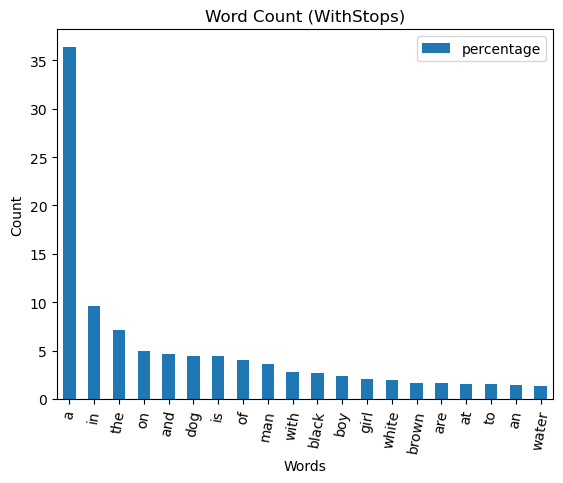

In [169]:
word_frequency = pd.DataFrame(data=tokenizer.word_counts.items(), columns=["word", "count"])
# Exclude start and end
exclude_words = ["start", "end"]
word_frequency = word_frequency[~word_frequency['word'].isin(exclude_words)]
# Sort the dataframe by count in descending order and select top 20
word_frequency = word_frequency.sort_values("count", ascending=False).head(20)
total_count = word_frequency['count'].sum()
# Calculate the percentage for each word
word_frequency['percentage'] = (word_frequency['count'] / total_count) * 100
# Plot the bar chart
word_frequency.set_index("word").plot(kind="bar", y = 'percentage', rot=0, title="Word Count (WithStops)")
plt.ylabel('Count')
plt.xlabel('Words')
plt.xticks(rotation=80)
# Display the plot
plt.show()

In [170]:
df2 = pd.read_pickle('caption2')
df2.rename(columns={2:'caption2'},inplace=True)
df2['caption2nostop'] = df2['caption2'].apply(remove_stop_words)
tokenizer2 = Tokenizer()
tokenizer2.fit_on_texts(df2['caption2nostop'])

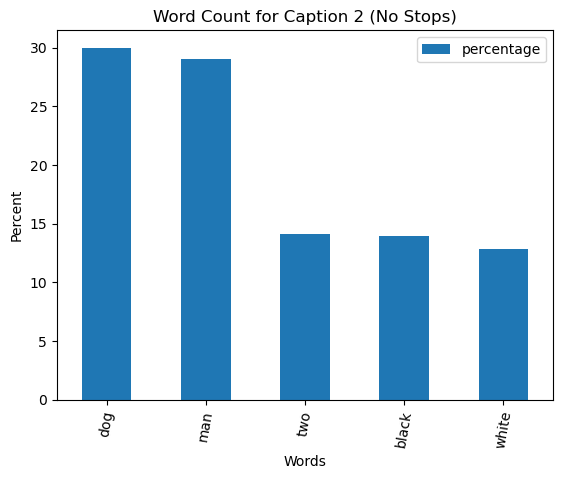

In [229]:
word_frequency = pd.DataFrame(data=tokenizer2.word_counts.items(), columns=["word", "count"])
# Exclude start and end
exclude_words = ["start", "end"]
word_frequency = word_frequency[~word_frequency['word'].isin(exclude_words)]
# Sort the dataframe by count in descending order and select top 5
word_frequency = word_frequency.sort_values("count", ascending=False).head(5)
total_count = word_frequency['count'].sum()
# Calculate the percentage for each word
word_frequency['percentage'] = (word_frequency['count'] / total_count) * 100
# Plot the bar chart
word_frequency.set_index("word").plot(kind="bar",y = 'percentage', rot=0, title="Word Count for Caption 2 (No Stops)")
plt.ylabel('Percent')
plt.xlabel('Words')
plt.xticks(rotation=80)
# Display the plot
plt.show()

In [214]:
df3 = pd.read_pickle('caption3')
df3.rename(columns={3:'caption3'},inplace=True)
df3['caption3nostop'] = df3['caption3'].apply(remove_stop_words)
tokenizer3 = Tokenizer()
tokenizer3.fit_on_texts(df3['caption3nostop'])

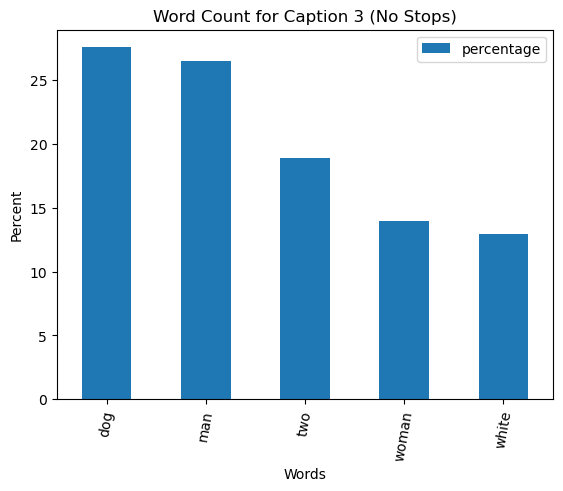

In [230]:
word_frequency = pd.DataFrame(data=tokenizer3.word_counts.items(), columns=["word", "count"])
# Exclude start and end
exclude_words = ["start", "end"]
word_frequency = word_frequency[~word_frequency['word'].isin(exclude_words)]
# Sort the dataframe by count in descending order and select top 5
word_frequency = word_frequency.sort_values("count", ascending=False).head(5)
total_count = word_frequency['count'].sum()
# Calculate the percentage for each word
word_frequency['percentage'] = (word_frequency['count'] / total_count) * 100
# Plot the bar chart
word_frequency.set_index("word").plot(kind="bar",y = 'percentage', rot=0, title="Word Count for Caption 3 (No Stops)")
plt.ylabel('Percent')
plt.xlabel('Words')
plt.xticks(rotation=80)
# Display the plot
plt.show()

In [218]:
df4 = pd.read_pickle('caption4')
df4.rename(columns={4:'caption4'},inplace=True)
df4['caption4nostop'] = df4['caption4'].apply(remove_stop_words)
tokenizer4 = Tokenizer()
tokenizer4.fit_on_texts(df4['caption4nostop'])

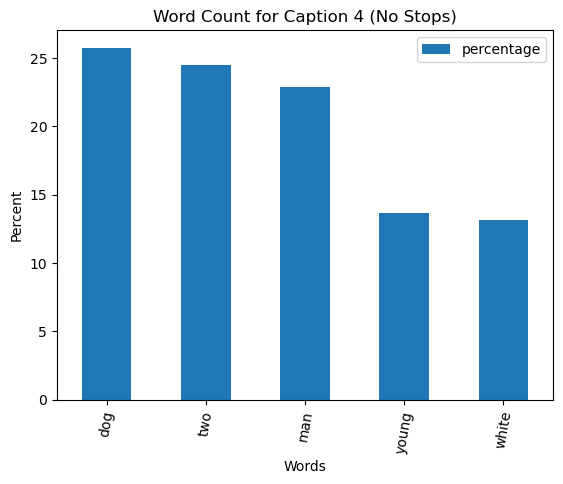

In [231]:
word_frequency = pd.DataFrame(data=tokenizer4.word_counts.items(), columns=["word", "count"])
# Exclude start and end
exclude_words = ["start", "end"]
word_frequency = word_frequency[~word_frequency['word'].isin(exclude_words)]
# Sort the dataframe by count in descending order and select top 5
word_frequency = word_frequency.sort_values("count", ascending=False).head(5)
total_count = word_frequency['count'].sum()
# Calculate the percentage for each word
word_frequency['percentage'] = (word_frequency['count'] / total_count) * 100
# Plot the bar chart
word_frequency.set_index("word").plot(kind="bar",y = 'percentage', rot=0, title="Word Count for Caption 4 (No Stops)")
plt.ylabel('Percent')
plt.xlabel('Words')
plt.xticks(rotation=80)
# Display the plot
plt.show()

In [220]:
df5 = pd.read_pickle('caption5')
df5.rename(columns={5:'caption5'},inplace=True)
df5['caption5nostop'] = df5['caption5'].apply(remove_stop_words)
tokenizer5 = Tokenizer()
tokenizer5.fit_on_texts(df5['caption5nostop'])

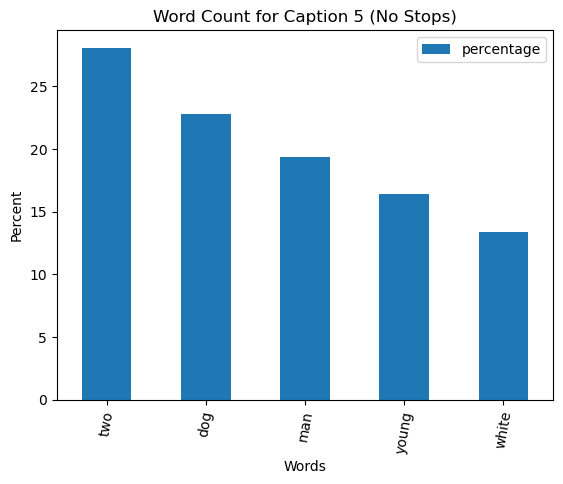

In [232]:
word_frequency = pd.DataFrame(data=tokenizer5.word_counts.items(), columns=["word", "count"])
# Exclude start and end
exclude_words = ["start", "end"]
word_frequency = word_frequency[~word_frequency['word'].isin(exclude_words)]
# Sort the dataframe by count in descending order and select top 5
word_frequency = word_frequency.sort_values("count", ascending=False).head(5)
total_count = word_frequency['count'].sum()
# Calculate the percentage for each word
word_frequency['percentage'] = (word_frequency['count'] / total_count) * 100
# Plot the bar chart
word_frequency.set_index("word").plot(kind="bar",y = 'percentage', rot=0, title="Word Count for Caption 5 (No Stops)")
plt.ylabel('Percent')
plt.xlabel('Words')
plt.xticks(rotation=80)
# Display the plot
plt.show()

## Splitting for training

Training split is performed after tokenizaton since the tensorflow tokenizer creates tokens based the frequency of word occurrence rather than a one-hot encoding. So, in order to be representative of the existence of completely new words during generation of caption, I will create the training split after tokenization. This captures the true maximum vocabulary present in the dataset.

In [172]:
#X is the image
#y is the tokenized caption. i will first try with stop words in because these captions are short
X = df1_sample['image']
y = df1_sample['tokenized']

In [173]:
y

6687    [3, 1, 181, 15, 7, 901, 17, 296, 48, 902, 400, 2]
6793    [3, 1, 484, 202, 4, 1, 28, 7, 13, 254, 8, 41, ...
7916               [3, 1, 9, 8, 41, 20, 105, 4, 5, 22, 2]
3742    [3, 1, 26, 10, 255, 42, 203, 12, 626, 627, 93,...
2122        [3, 1, 9, 12, 1, 161, 4, 47, 10, 1, 17, 9, 2]
                              ...                        
3606           [3, 1, 14, 69, 36, 5, 74, 199, 214, 28, 2]
5704         [3, 1, 11, 127, 1, 437, 1979, 52, 1, 177, 2]
6637    [3, 1, 11, 124, 25, 210, 52, 23, 35, 92, 20, 3...
2575    [3, 1, 762, 1980, 5, 1981, 10, 296, 8, 895, 4,...
7336       [3, 1, 17, 9, 158, 52, 20, 216, 21, 67, 78, 2]
Name: tokenized, Length: 1618, dtype: object

In [174]:
X_remain, X_test, y_remain, y_test = train_test_split(X, y, train_size=0.85, random_state=2)

In [175]:
X_remain.shape

(1375,)

In [176]:
X_train, X_val, y_train, y_val = train_test_split(X_remain, y_remain, train_size=0.935, random_state=2)

In [226]:
X_train.shape

(1285,)

In [177]:
X_val.shape

(90,)

In [178]:
traindirectory = 'flickr8k/images/train'
testdirectory = 'flickr8k/images/test'
valdirectory = 'flickr8k/images/val'

In [179]:
for filename in X_test:
    source_path = os.path.join(imagefolder, filename)
    destination_path = os.path.join(testdirectory, filename)
    shutil.copyfile(source_path, destination_path)

for filename in X_train:
    source_path = os.path.join(imagefolder, filename)
    destination_path = os.path.join(traindirectory, filename)
    shutil.copyfile(source_path, destination_path)

for filename in X_val:
    source_path = os.path.join(imagefolder, filename)
    destination_path = os.path.join(valdirectory, filename)
    shutil.copyfile(source_path, destination_path)

In [180]:
X_train.to_pickle('trainpics')
X_test.to_pickle('testpics')
X_val.to_pickle('valpics')

In [181]:
y_val.to_pickle('valtokens')
y_train.to_pickle('traintokens')
y_test.to_pickle('testtokens')

In [182]:
y_train = pd.read_pickle('traintokens')

## Split notebook here later

In [183]:
Xdf = pd.DataFrame(X_train)
ydf = pd.DataFrame(y_train)
train_df = pd.concat([Xdf, ydf], axis=1)
train_df

,image,tokenized
3803,3042484940_0975a5e486.jpg,"[3, 1, 11, 107, 52, 21, 796, 561, 23, 222, 7, ..."
3912,307321761_606fc91673.jpg,"[3, 1, 26, 10, 64, 4, 594, 143, 109, 2]"
4410,3187395715_f2940c2b72.jpg,"[3, 1, 14, 6, 111, 8, 291, 1, 118, 55, 1, 30, ..."
4124,3123351642_3794f2f601.jpg,"[3, 1, 383, 4, 384, 43, 290, 1, 118, 19, 1, 69..."
5320,3372022051_132b8e6233.jpg,"[3, 1, 14, 8, 422, 6, 1, 148, 368, 21, 514, 10..."
...,...,...
6585,3626642428_3396568c3c.jpg,"[3, 1, 26, 10, 42, 35, 4, 1, 226, 2]"
548,1499581619_a5f65a882c.jpg,"[3, 1, 136, 85, 4, 1834, 440, 6, 5, 50, 2]"
1363,226531363_33ac01d931.jpg,"[3, 1, 9, 60, 99, 5, 115, 59, 2]"
4131,3124964754_2e8a98fb09.jpg,"[3, 1, 11, 41, 1, 842, 23, 344, 2]"


In [184]:
traindict = {}

for _, row in train_df.iterrows():
    image_path = row['image']
    caption = row['tokenized']
    if image_path in traindict:
        traindict[image_path].append(caption)
    else:
        traindict[image_path] = [caption]

traindict = {key: value[0] for key, value in traindict.items()}
traindict

{'3042484940_0975a5e486.jpg': [3,
  1,
  11,
  107,
  52,
  21,
  796,
  561,
  23,
  222,
  7,
  38,
  223,
  326,
  6,
  2],
 '307321761_606fc91673.jpg': [3, 1, 26, 10, 64, 4, 594, 143, 109, 2],
 '3187395715_f2940c2b72.jpg': [3,
  1,
  14,
  6,
  111,
  8,
  291,
  1,
  118,
  55,
  1,
  30,
  190,
  169,
  1,
  16,
  116,
  2],
 '3123351642_3794f2f601.jpg': [3,
  1,
  383,
  4,
  384,
  43,
  290,
  1,
  118,
  19,
  1,
  699,
  2],
 '3372022051_132b8e6233.jpg': [3,
  1,
  14,
  8,
  422,
  6,
  1,
  148,
  368,
  21,
  514,
  1012,
  53,
  1,
  666,
  2],
 '3294830188_e46bd9b93c.jpg': [3,
  1,
  660,
  10,
  365,
  405,
  264,
  12,
  522,
  4,
  93,
  982,
  2],
 '3372215826_b3e6403b2e.jpg': [3, 1, 11, 4, 1, 173, 88, 1444, 1, 1445, 2],
 '3457315666_b943111dec.jpg': [3,
  1,
  445,
  433,
  69,
  45,
  509,
  19,
  21,
  497,
  1852,
  262,
  2],
 '3259992722_4c5e895734.jpg': [3,
  1,
  71,
  4,
  1,
  904,
  905,
  236,
  1,
  43,
  906,
  11,
  2],
 '2423085253_6c19149855.jpg': [

In [185]:
## WORKS TO GET THE ARRAYS OF SEQUENCES

SEQUENCE_LENGTH = 2

ins = []
outs = []
names = []

for i, t in traindict.items():
    for l in range(1, len(t)):
        inseq = t[:l]
        outseq = t[l]
        inseq = pad_sequences([inseq], maxlen=max_length, padding='post')[0]
        outseq = to_categorical([outseq], num_classes=vocab_size)[0]
        ins.append(inseq)
        outs.append(outseq)
        names.append(i)

ins = np.array(ins)
outs = np.array(outs)
names = np.array(names)

print(ins.shape)
print(outs.shape)
print(names.shape)

(15628, 33)
(15628, 1982)
(15628,)


In [186]:
namesdf = pd.DataFrame(names)
insdf = pd.DataFrame(ins)
outsdf = pd.DataFrame(outs)

In [187]:
namesdf = namesdf.rename(columns={
    0:'filename',
})

In [188]:
columnames = ['in_'+str(col) for col in insdf.columns]
insdf.columns = columnames
insdf

,in_0,in_1,in_2,in_3,in_4,in_5,in_6,in_7,in_8,in_9,...,in_23,in_24,in_25,in_26,in_27,in_28,in_29,in_30,in_31,in_32
0,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,1,11,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,1,11,107,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,3,1,11,107,52,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15623,3,1,79,100,344,6,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15624,3,1,79,100,344,6,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15625,3,1,79,100,344,6,1,110,0,0,...,0,0,0,0,0,0,0,0,0,0
15626,3,1,79,100,344,6,1,110,402,0,...,0,0,0,0,0,0,0,0,0,0


In [189]:
columnames = ['out_'+str(col) for col in outsdf.columns]
outsdf.columns = columnames
outsdf

,out_0,out_1,out_2,out_3,out_4,out_5,out_6,out_7,out_8,out_9,...,out_1972,out_1973,out_1974,out_1975,out_1976,out_1977,out_1978,out_1979,out_1980,out_1981
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15623,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15624,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15625,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15626,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [190]:
traindffull = pd.concat([namesdf, insdf, outsdf], axis=1)

In [191]:
pic1 = traindffull[traindffull['filename']=='3665569615_9a71c4b6e4.jpg']
pic1

,filename,in_0,in_1,in_2,in_3,in_4,in_5,in_6,in_7,in_8,...,out_1972,out_1973,out_1974,out_1975,out_1976,out_1977,out_1978,out_1979,out_1980,out_1981
11717,3665569615_9a71c4b6e4.jpg,3,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11718,3665569615_9a71c4b6e4.jpg,3,1,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11719,3665569615_9a71c4b6e4.jpg,3,1,168,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11720,3665569615_9a71c4b6e4.jpg,3,1,168,1646,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11721,3665569615_9a71c4b6e4.jpg,3,1,168,1646,34,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11722,3665569615_9a71c4b6e4.jpg,3,1,168,1646,34,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11723,3665569615_9a71c4b6e4.jpg,3,1,168,1646,34,1,16,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11724,3665569615_9a71c4b6e4.jpg,3,1,168,1646,34,1,16,7,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11725,3665569615_9a71c4b6e4.jpg,3,1,168,1646,34,1,16,7,28,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11726,3665569615_9a71c4b6e4.jpg,3,1,168,1646,34,1,16,7,28,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


[[[0.3647059  0.32941177 0.07450981]
  [0.36862746 0.33333334 0.07843138]
  [0.38039216 0.34117648 0.09803922]
  ...
  [0.28627452 0.27058825 0.02352941]
  [0.28627452 0.2627451  0.02745098]
  [0.28627452 0.2627451  0.03529412]]

 [[0.34509805 0.30980393 0.05490196]
  [0.36862746 0.33333334 0.07843138]
  [0.3529412  0.31764707 0.0627451 ]
  ...
  [0.29803923 0.2784314  0.01176471]
  [0.3019608  0.28235295 0.01568628]
  [0.3137255  0.29411766 0.02745098]]

 [[0.34901962 0.3137255  0.05882353]
  [0.35686275 0.32156864 0.06666667]
  [0.35686275 0.32156864 0.05882353]
  ...
  [0.32156864 0.29803923 0.00784314]
  [0.32941177 0.30588236 0.01568628]
  [0.32941177 0.30588236 0.01568628]]

 ...

 [[0.7176471  0.33333334 0.14901961]
  [0.70980394 0.33333334 0.13725491]
  [0.7294118  0.3529412  0.15294118]
  ...
  [0.7490196  0.3882353  0.1882353 ]
  [0.7294118  0.36078432 0.16078432]
  [0.7137255  0.34509805 0.14509805]]

 [[0.7372549  0.3529412  0.1764706 ]
  [0.7294118  0.3529412  0.15686275]


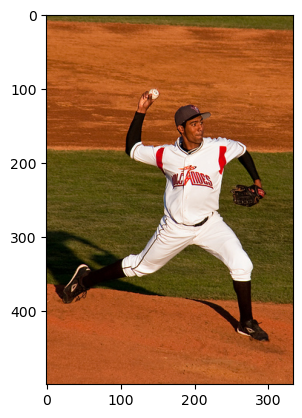

In [83]:
#checking a picture
for filename in names:
        imgpath = os.path.join(traindirectory, filename)
        imgload = load_img(imgpath)
        imgarray = img_to_array(imgload)/255.
        plt.imshow(imgarray)
        print(imgarray)
        break

In [192]:
#TRAIN GENERATOR
def infogen(names, ins, outs, batch_size):
    insgen = []
    outsgen = []
    imgsgen = []
    n = 0
    while True:
        for i, filename in enumerate(names):
            imgpath = os.path.join(traindirectory, filename)
            imgload = load_img(imgpath)
            imgresized = imgload.resize((imagesize, imagesize))
            imgarray = img_to_array(imgresized)/255.
            insgen.append(ins[i])
            outsgen.append(outs[i])
            imgsgen.append(imgarray)
            n+=1
            if n == batch_size:
                yield [[array(imgsgen), array(insgen)], array(outsgen)]
                insgen = []
                outsgen = []
                imgsgen = []
                n = 0
    


In [193]:
#GENERATOR USE
batch_size = 5
infogenerator = infogen(names,ins,outs, batch_size)
[n1,in1],ou1 = next(infogenerator)
print(n1.shape)
print(in1.shape)
print(ou1.shape)

(5, 224, 224, 3)
(5, 33)
(5, 1982)


## Validation Set

In [194]:
Xvaldf = pd.DataFrame(X_val)
yvaldf = pd.DataFrame(y_val)
val_df = pd.concat([Xvaldf, yvaldf], axis=1)
val_df

,image,tokenized
1178,2193223202_4d908c0450.jpg,"[3, 1, 14, 283, 1, 117, 55, 38, 14, 2]"
5228,3353328134_dd9ed0edab.jpg,"[3, 1, 256, 139, 1, 320, 4, 1, 358, 122, 2]"
7839,689776124_07f560a920.jpg,"[3, 1, 13, 9, 8, 635, 39, 36, 5, 40, 2]"
2456,2623146491_b64698b875.jpg,"[3, 1, 11, 4, 13, 8, 1146, 214, 19, 5, 1147, 4..."
138,1148238960_f8cacec2fc.jpg,"[3, 1026, 18, 35, 19, 21, 1027, 2]"
...,...,...
2028,247637795_fdf26a03cf.jpg,"[3, 1, 11, 7, 1, 24, 19, 5, 1681, 2]"
1222,2206600240_f65df56a09.jpg,"[3, 1, 245, 171, 7, 1, 1149, 11, 564, 45, 1, 1..."
4007,3096918227_f9d26a7db2.jpg,"[3, 1, 592, 8, 290, 1, 1273, 154, 23, 1274, 36..."
474,1446933195_8fe9725d62.jpg,"[3, 1, 13, 305, 8, 333, 1, 157, 720, 2]"


In [195]:
valdict = {}

for _, row in val_df.iterrows():
    image_path = row['image']
    caption = row['tokenized']
    if image_path in valdict:
        valdict[image_path].append(caption)
    else:
        valdict[image_path] = [caption]

valdict = {key: value[0] for key, value in valdict.items()}
valdict

{'2193223202_4d908c0450.jpg': [3, 1, 14, 283, 1, 117, 55, 38, 14, 2],
 '3353328134_dd9ed0edab.jpg': [3, 1, 256, 139, 1, 320, 4, 1, 358, 122, 2],
 '689776124_07f560a920.jpg': [3, 1, 13, 9, 8, 635, 39, 36, 5, 40, 2],
 '2623146491_b64698b875.jpg': [3,
  1,
  11,
  4,
  13,
  8,
  1146,
  214,
  19,
  5,
  1147,
  4,
  1,
  563,
  2],
 '1148238960_f8cacec2fc.jpg': [3, 1026, 18, 35, 19, 21, 1027, 2],
 '3174196837_800689a2f3.jpg': [3, 1, 26, 10, 42, 145, 36, 5, 115, 59, 2],
 '539750844_02a07ec524.jpg': [3, 1, 9, 91, 12, 1, 76, 32, 2],
 '3109268897_d43797fc6a.jpg': [3, 21, 245, 1679, 310, 1680, 85, 2],
 '2252264255_03fefc25af.jpg': [3,
  27,
  102,
  338,
  1962,
  33,
  6,
  1,
  623,
  155,
  356,
  2],
 '2612608861_92beaa3d0b.jpg': [3, 1, 26, 10, 64, 89, 19, 214, 1079, 2],
 '3437781040_82b06facb3.jpg': [3,
  21,
  478,
  380,
  56,
  4,
  28,
  8,
  1423,
  5,
  56,
  4,
  16,
  61,
  5,
  1424,
  2],
 '2602258549_7401a3cdae.jpg': [3, 1, 136, 4, 1, 369, 18, 51, 210, 2],
 '300148649_72f7f03

In [196]:
valins = []
valouts = []
valnames = []

for i, t in valdict.items():
    for l in range(1, len(t)):
        inseq = t[:l]
        outseq = t[l]
        inseq = pad_sequences([inseq], maxlen=max_length, padding='post')[0]
        outseq = to_categorical([outseq], num_classes=vocab_size)[0]
        valins.append(inseq)
        valouts.append(outseq)
        valnames.append(i)

valins = np.array(valins)
valouts = np.array(valouts)
valnames = np.array(valnames)

print(valins.shape)
print(valouts.shape)
print(valnames.shape)

(990, 33)
(990, 1982)
(990,)


In [197]:
#VAL GENERATOR
# def valgen(valnames, valins, valouts):
valinsgen = []
valoutsgen = []
valimgsgen = []

for i, filename in enumerate(valnames):
    imgpath = os.path.join(valdirectory, filename)
    imgload = load_img(imgpath)
    imgresized = imgload.resize((imagesize, imagesize))
    imgarray = img_to_array(imgresized)/255.
    valinsgen.append(valins[i])
    valoutsgen.append(valouts[i])
    valimgsgen.append(imgarray)
valimgsgen = array(valimgsgen)
valinsgen = array(valinsgen)
valoutsgen = array(valoutsgen)

print(valimgsgen.shape)
print(valinsgen.shape)
print(valoutsgen.shape)


(990, 224, 224, 3)
(990, 33)
(990, 1982)


Modeling using Efficientnetv2s

In [198]:
basemodel = EfficientNetV2S(
    weights='imagenet',
    include_preprocessing=False,
    include_top=False,
)
basemodel.summary()

Model: "efficientnetv2-s"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 stem_conv (Conv2D)             (None, None, None,   648         ['input_10[0][0]']               
                                24)                                                               
                                                                                                  
 stem_bn (BatchNormalization)   (None, None, None,   96          ['stem_conv[0][0]']              
                                24)                                                

In [199]:
for layer in basemodel.layers:
    layer.trainable = False

In [200]:
inputs1 = Input(shape=(224, 224, 3))
flat = Flatten()(inputs1)
fe1 = Dropout(0.5)(flat)
fe2 = Dense(256, activation='relu')(fe1)

inputs2 = Input(shape=(max_length))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

decoder1 = Add()([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
output = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs = [inputs1, inputs2], outputs = output)

In [201]:
model.compile(loss = 'categorical_crossentropy', 
                  optimizer = 'Adam', 
                  metrics = ['accuracy'],
                  run_eagerly=True)

In [202]:
steps = len(ins)/batch_size
batch_size = 10

In [203]:
history1 = model.fit(infogenerator,
            epochs = 15,
            steps_per_epoch=steps,
            verbose=1,
            validation_data=([valimgsgen, valinsgen], valoutsgen),
            validation_batch_size=10)

Epoch 1/15
3125/3125 [==============================] - 1171s 374ms/step - loss: 4.8846 - accuracy: 0.2403 - val_loss: 4.2839 - val_accuracy: 0.2869
Epoch 2/15
3125/3125 [==============================] - 1169s 374ms/step - loss: 3.8588 - accuracy: 0.2970 - val_loss: 4.2762 - val_accuracy: 0.3081
Epoch 3/15
3125/3125 [==============================] - 1176s 376ms/step - loss: 3.5054 - accuracy: 0.3199 - val_loss: 4.3652 - val_accuracy: 0.3202
Epoch 4/15
3125/3125 [==============================] - 1171s 375ms/step - loss: 3.2640 - accuracy: 0.3366 - val_loss: 4.4816 - val_accuracy: 0.3242
Epoch 5/15
3125/3125 [==============================] - 1170s 374ms/step - loss: 3.1209 - accuracy: 0.3499 - val_loss: 4.6346 - val_accuracy: 0.3192
Epoch 6/15
3125/3125 [==============================] - 1175s 376ms/step - loss: 2.8573 - accuracy: 0.3614 - val_loss: 4.8779 - val_accuracy: 0.3212
Epoch 7/15
3125/3125 [==============================] - 1164s 372ms/step - loss: 2.6897 - accuracy: 0.3752

In [204]:
model.save('model_15epochs' + '.h5')

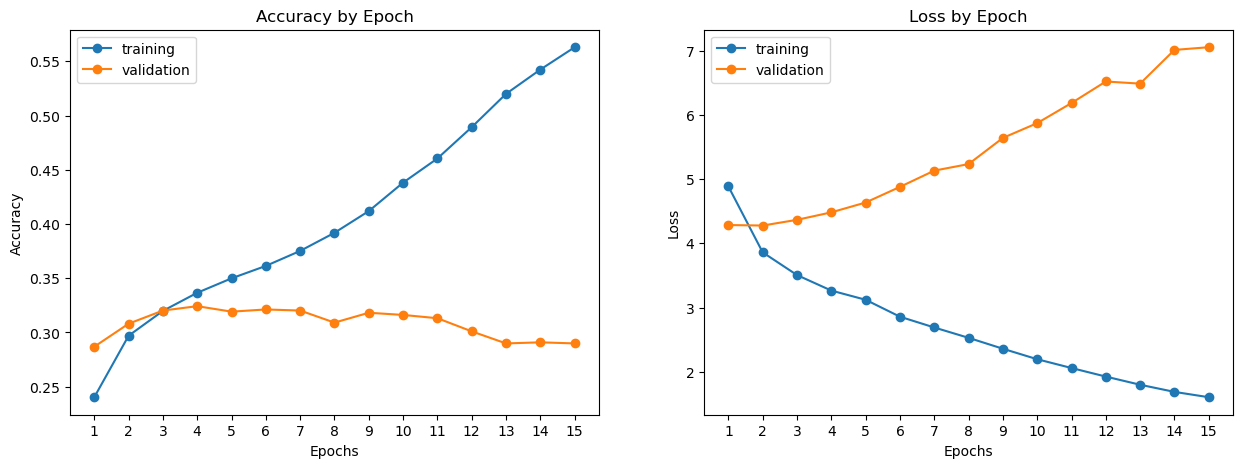

In [208]:
epochs = range(1, 16)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, history1.history["accuracy"], label="training", marker="o")
plt.plot(epochs, history1.history["val_accuracy"], label="validation", marker="o")
plt.xlabel("Epochs")
plt.xticks(epochs)
plt.ylabel("Accuracy")
plt.title('Accuracy by Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, history1.history["loss"], label="training", marker="o")
plt.plot(epochs, history1.history["val_loss"], label="validation", marker="o")
plt.xlabel("Epochs")
plt.xticks(epochs)
plt.ylabel("Loss")
plt.title('Loss by Epoch')
plt.legend()
plt.show()